Package imports and general function constructions

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os
import random as rand

dir_list = os.listdir('Primary Care Calibration\\Manually Validated Participants')
calList = pandas.read_excel('Primary Care Calibration\\Manually Validated Participants\\Calibration List.xlsx').to_numpy()

def dataClean(data, reg=np.array([[0, 1920], [0, 1080]])):
    for l in range(len(data[:, 0])):
        if data[l, 4]<reg[0, 0] or data[l, 4]>reg[0, 1] or data[l, 5]<reg[1, 0] or data[l, 5]>reg[1, 1]:
            data[l, 3] = 0

    validData = np.zeros(shape=(int(sum(data[:, 3])), 6))

    j = 0
    for k in range(len(data[:, 0])):
        if data[k, 3] == 1:
            validData[j, :] = data[k, :]
            j= j + 1
    return validData

def com(data):
    m = len(data[:, 0])
    dataCom = ((data.T  @ np.ones(m)[None].T)/m).T[0]
    return dataCom

def homogenize(data, comAvg):
    dataCom = com(data)
    dispMatr = np.ones(len(data[:, 0]))[None].T @ (comAvg-dataCom)[None]
    return data+dispMatr

def uniVary(data, width):
    m = len(data[:, 0])
    dispMatr = np.ones(m)[None].T @ (np.array([(rand.random()-0.5)*width, (rand.random()-0.5)*width]))[None]
    return dispMatr[0, :], data + dispMatr

Boundary definitions for speedometer, side mirror, etc, as well as functions to calculat the COMs in each region. 

In [2]:
sm = np.array([[0, 550], [200, 600]])
speedom = np.array([[820, 1000], [200, 400]])
rv = np.array([[1250, 1900], [540, 800]])
road = np.array([[600, 1050], [400, 550]])
panel = np.array([[1240, 1640], [0, 270]])

def regConv(region, comAvgs, comSDs):
    newReg = region - (np.ones(2)[None].T @ comAvgs[None]).T + 2*(np.array([-1, 1])[None].T @ comSDs[None]).T
    return newReg

comAvgs = np.array([997.388, 460.393])
comSDs = np.array([28.058, 29.206])

newSm = regConv(sm, comAvgs, comSDs)
newSpeedom = regConv(speedom, comAvgs, comSDs)
newRv = regConv(rv, comAvgs, comSDs)
newRoad = regConv(road, comAvgs, comSDs)
newPanel = regConv(panel, comAvgs, comSDs)

def regComs(validData):
    n = len(validData[:, 4])

    avgs = ((validData[:, 4:].T  @ np.ones(n)[None].T)/n).T[0]

    dispMatr = np.ones(len(validData[:, 0]))[None].T @ avgs[None]
    validData[:, 4:] = validData[:, 4:] - dispMatr

    smData = dataClean(validData, newSm)
    validData[:, 3] = np.ones(n)
    speedomData = dataClean(validData, newSpeedom)
    validData[:, 3] = np.ones(n)
    rvData = dataClean(validData, newRv)
    validData[:, 3] = np.ones(n)
    roadData = dataClean(validData, newRoad)
    validData[:, 3] = np.ones(n)
    panelData = dataClean(validData, newPanel)

    m1 = len(smData[:, 4])
    smAvgs = ((smData[:, 4:].T  @ np.ones(m1)[None].T)/m1).T[0]
    m2 = len(speedomData[:, 4])
    speedomAvgs = ((speedomData[:, 4:].T  @ np.ones(m2)[None].T)/m2).T[0]
    m3 = len(rvData[:, 4])
    rvAvgs = ((rvData[:, 4:].T  @ np.ones(m3)[None].T)/m3).T[0]
    m4 = len(roadData[:, 4])
    roadAvgs = ((roadData[:, 4:].T  @ np.ones(m4)[None].T)/m4).T[0]
    m5 = len(panelData[:, 4])
    panelAvgs = ((panelData[:, 4:].T  @ np.ones(m5)[None].T)/m5).T[0]
    
    return np.array([n, m1, m2, m3, m4, m5]), np.array([avgs, smAvgs + avgs, speedomAvgs + avgs, rvAvgs + avgs, roadAvgs + avgs, panelAvgs + avgs])

[ 116.89103156 -345.26448548]


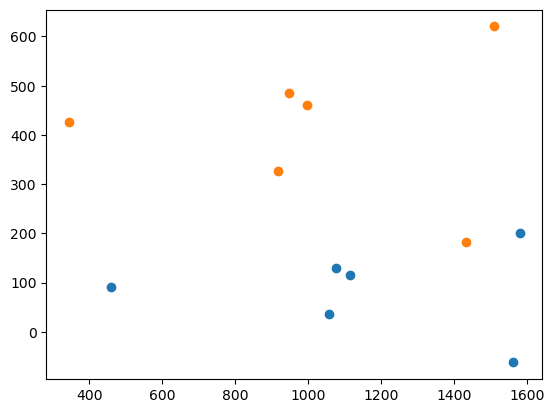

In [33]:
weightedComs = np.array([[997.38843601, 460.39347341], [344.60451466, 425.89224779], [917.53970669, 326.09152263], 
                         [1508.28180109, 620.31235517], [947.2402873, 484.27144892], [1430.97495163, 181.77568594]])

inds = np.zeros(len(dir_list)-1)
for i in range(len(dir_list)-1):
    if calList[i, 1]=='Good' or calList[i, 1]=='Offset':
        inds[i] = 1

trueOffset = np.zeros(shape=(2, int(sum(inds))))
avgCorr = np.zeros(shape=(2, int(sum(inds))))
p = 0
for i in range(len(dir_list)-1):
    if inds[i]==1:
        data = pandas.read_csv('Primary Care Calibration\\Manually Validated Participants\\' + str(dir_list[i+1])).to_numpy()
        randData = dataClean(data)
        trueOffset[:, p], randData[:, 4:] = uniVary(homogenize(randData[:, 4:], comAvgs), 1000)
        comWeights, coms = regComs(randData)
        comDifs = (weightedComs - coms)
        avgCorr[:, p] = (comDifs.T @ (comWeights[None].T @ np.array([1, 1])[None])/sum(comWeights))[:, 0]
        if i == 8:
            print(trueOffset[:, p])
            plt.plot(coms[:, 0], coms[:, 1], 'o')
            plt.plot(weightedComs[:, 0], weightedComs[:, 1], 'o')
        p = p + 1

plt.show()

[[  9.42051745   3.23238814  -7.93290525   0.84619604   1.67652597
    5.34488735  -7.67220381   7.58562254   4.75671124 -37.28680942
   -0.39973228  -4.74025716  10.05271802   6.80442907   3.04128674
    5.41770389  17.64670906   2.59640224  -0.04475804  -2.64802998
    6.42601074   6.4279045    6.19451437   4.10759588  -3.52212578
  -12.40034218   5.16415917   0.65271001   0.96141728   1.2377458
    8.61453306   2.21892863  14.01277142  -1.95620577   5.62460116
    0.63344914   2.42441052   5.27139657   6.76658006  15.62603112
   -0.74786234   7.62770545   6.47007389  13.94519718   0.3672605
    2.81140793  -5.04135814   7.19687775   3.12437818  -0.12429827
    8.86440865  -0.14552226  -7.81830752   7.03478081   6.69449927
    8.81596937   9.89962458  -8.1513961    6.4262461    2.81157711
    4.14497192  12.5614251    6.51259244]
 [  6.03476882   3.59845688   5.29818441   2.38080866   4.20177622
    7.15040661   5.1556021    4.40581695   1.81085023   7.11229078
    4.67886316   2.308

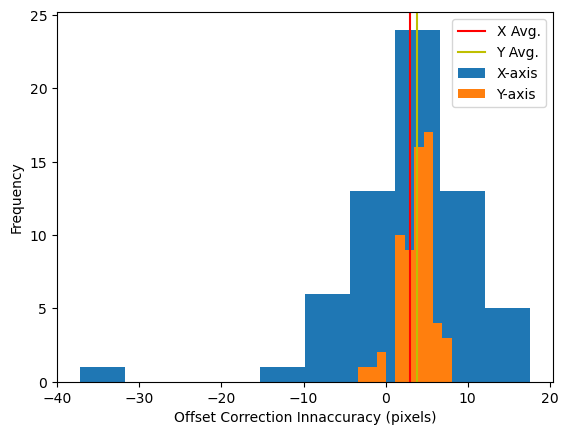

In [34]:
print((-trueOffset - avgCorr))

plt.hist((-trueOffset - avgCorr)[0, :])
plt.hist((-trueOffset - avgCorr)[1, :])
xavg = sum((-trueOffset - avgCorr)[0, :])/len((-trueOffset - avgCorr)[0, :])
yavg = sum((-trueOffset - avgCorr)[1, :])/len((-trueOffset - avgCorr)[1, :])
plt.axvline(x=xavg, color='r')
plt.axvline(x=yavg, color='y')
plt.legend(['X Avg.', 'Y Avg.', 'X-axis', 'Y-axis'])
plt.xlabel('Offset Correction Innaccuracy (pixels)')
plt.ylabel('Frequency')
plt.show()

['E051' 'Good' 0.9279014162221814 64.60292721894041]
[[ 997.388       460.393     ]
 [ 427.67673981  440.5970567 ]
 [ 958.84783768  380.32285944]
 [1473.44281109  587.52055955]
 [ 976.7255182   477.7376332 ]
 [1452.54082151  219.04363645]]


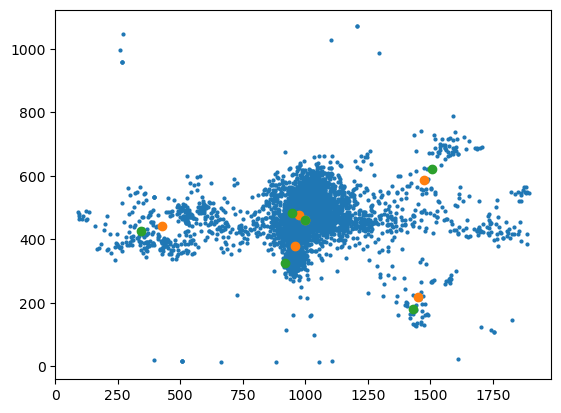

In [182]:
i = 17
data = pandas.read_csv('Primary Care Calibration\\Manually Validated Participants\\' + str(dir_list[i+1])).to_numpy()

print(calList[i])
# plt.plot(data[:, 4], data[:, 5], 'o', markersize=2)

validData = dataClean(data)
validData[:, 4:] = homogenize(validData[:, 4:], comAvgs)
w, coms = regComs(validData)
print(coms)
plt.plot(validData[:, 4], validData[:, 5], 'o', markersize=2)
plt.plot(coms[:, 0], coms[:, 1], 'o')
plt.plot(weightedComs[:, 0], weightedComs[:, 1], 'o')
plt.show()